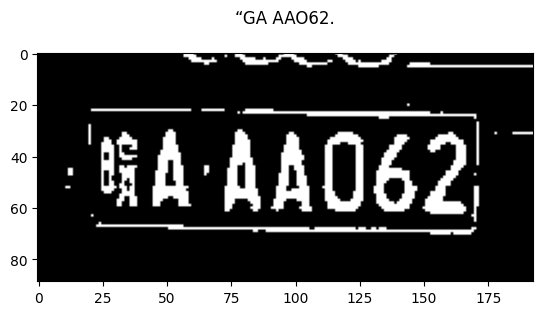

In [345]:
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

lp_images_path = 'cropped_lps/'
lp_images = os.listdir(lp_images_path)

test_image_path = lp_images[0]
test_image = cv2.imread(lp_images_path + test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Set the threshold value
threshold_value = 180  # Adjust this value based on your requirement

# Apply binary thresholding
_, thresholded_image = cv2.threshold(test_image, threshold_value, 255, cv2.THRESH_BINARY)

plt.title(pytesseract.image_to_string(thresholded_image))
plt.imshow(thresholded_image, cmap='gray')
plt.show()

In [346]:
# backup

# this might be the best one, lps should probably be cropped to exactly 150x50
# maybe swap morph and hist ?!
# prep2 = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
# prep2 = cv2.morphologyEx(prep2, cv2.MORPH_BLACKHAT, np.ones((150,50), np.uint8))
# prep2 = cv2.equalizeHist(prep2)

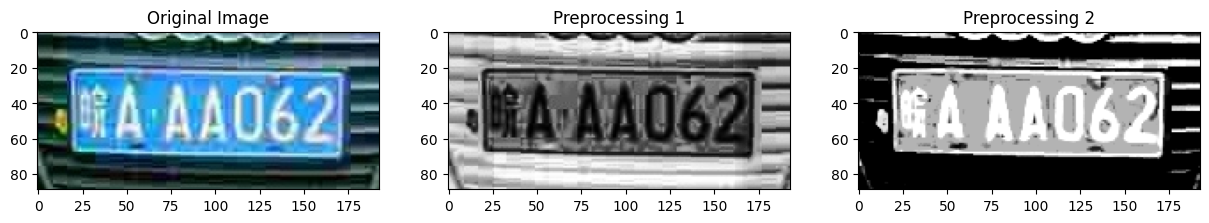

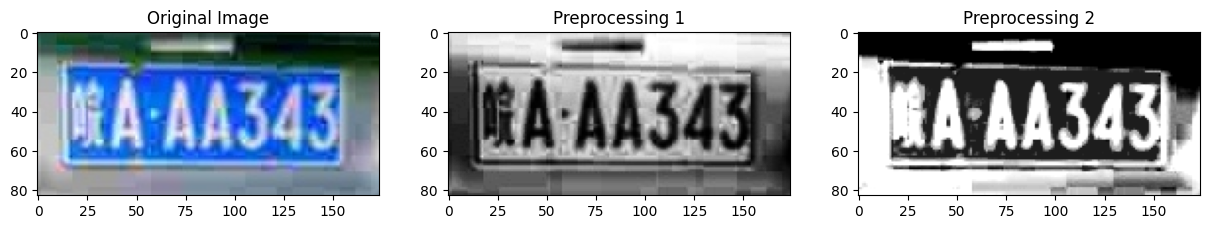

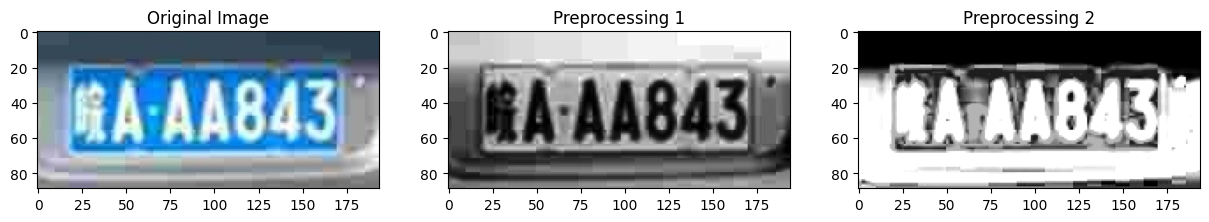

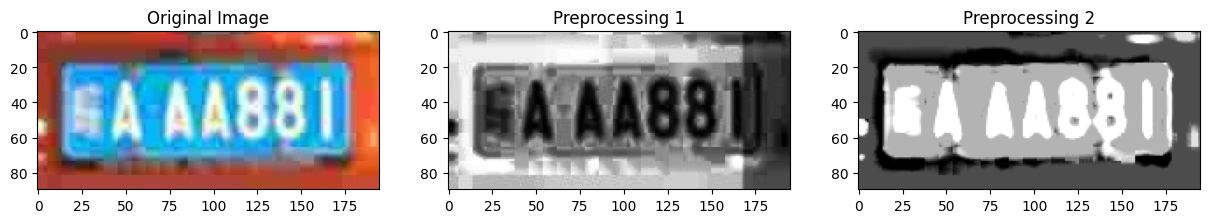

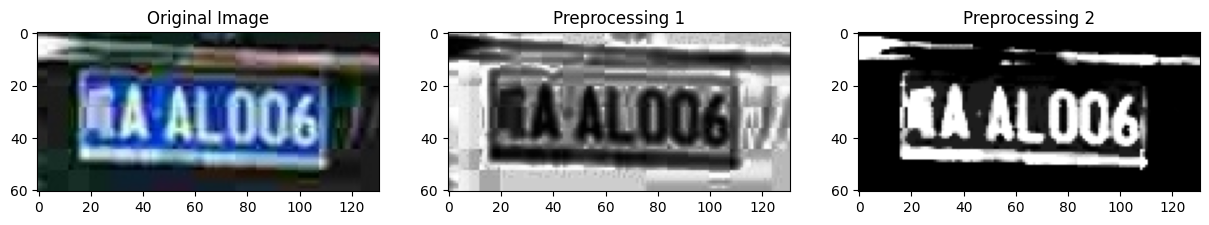

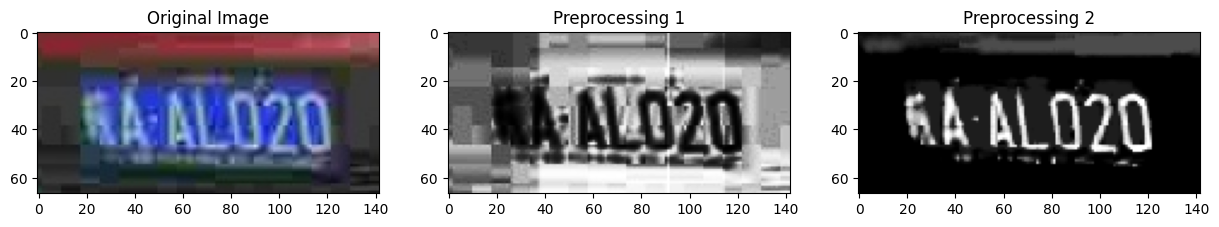

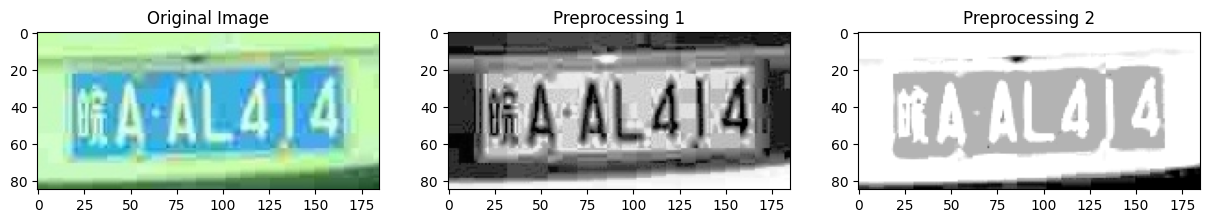

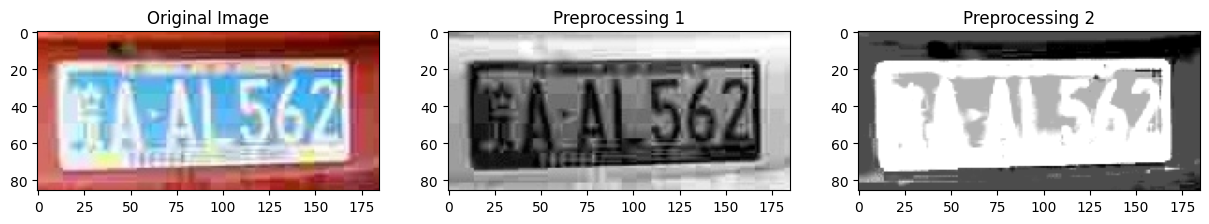

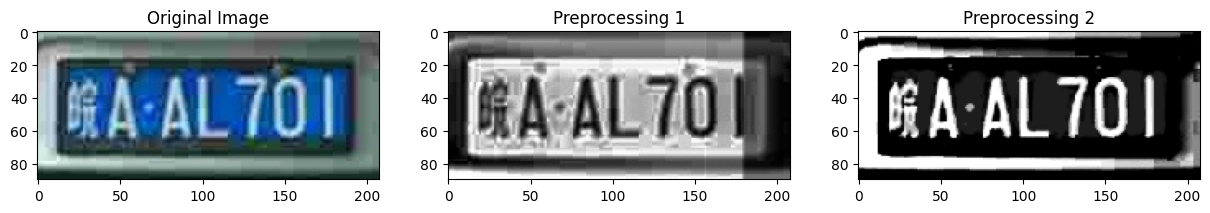

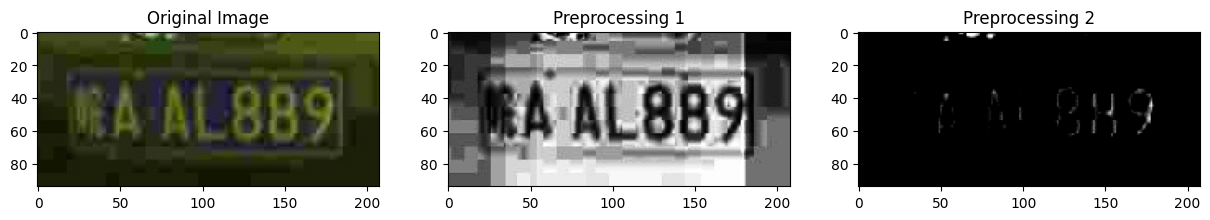

In [347]:
import cv2
import numpy as np

def plot_preprocessing(img_path):
    original = cv2.imread(img_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # compare original with two preprocessed versions
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(original_rgb)

    # preprocessing 1
    prep = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    prep = cv2.morphologyEx(prep, cv2.MORPH_BLACKHAT, np.ones((150,50), np.uint8))
    prep = cv2.equalizeHist(prep)

    plt.subplot(1,3,2)
    plt.title('Preprocessing 1')
    plt.imshow(prep, cmap='gray')

    # preprocessing 2
    # prep = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    # prep = cv2.morphologyEx(prep, cv2.MORPH_BLACKHAT, np.ones((150,50), np.uint8))
    # prep = cv2.equalizeHist(prep)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # prep = cv2.morphologyEx(prep, cv2.MORPH_OPEN, kernel)

    prep = original.copy()

    contrast = 100
    f = 131*(contrast + 127)/(127*(131-contrast))
    alpha_c = f
    gamma_c = 127*(1-f)
    prep = cv2.addWeighted(prep, alpha_c, prep, 0, gamma_c)

    prep = cv2.cvtColor(prep, cv2.COLOR_BGR2GRAY)
    # prep = cv2.GaussianBlur(prep, (5, 5), 50) 
    # prep = cv2.dilate(prep, np.ones((3,3)), iterations=2)

    # prep = cv2.equalizeHist(prep)

    plt.subplot(1,3,3)
    plt.title('Preprocessing 2')
    plt.imshow(prep, cmap='gray')

    plt.show()

for image in lp_images[:10]:
    plot_preprocessing(lp_images_path + image)

In [348]:
lp_width_px = 300
lp_height_px = 100

def best_rect(contours, eps):
    biggest = np.array([])
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, eps * peri, True)
            print(len(approx))
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def draw_rect(contour, img):
    cv2.line(img, tuple(contour[0][0]), tuple(contour[1][0]), (0, 255, 0), 2)
    cv2.line(img, tuple(contour[1][0]), tuple(contour[3][0]), (0, 255, 0), 2)
    cv2.line(img, tuple(contour[2][0]), tuple(contour[0][0]), (0, 255, 0), 2)
    cv2.line(img, tuple(contour[3][0]), tuple(contour[2][0]), (0, 255, 0), 2)
    cv2.drawContours(img, contour, -1, (180, 0, 255), 5)
    return img

def reorder_points(contour):
    contour = contour.reshape((4, 2))
    contour_new = np.zeros((4, 1, 2), dtype=np.int32)
    add = contour.sum(1)
    contour_new[0] = contour[np.argmin(add)]
    contour_new[3] = contour[np.argmax(add)]
    diff = np.diff(contour, axis=1)
    contour_new[1] = contour[np.argmin(diff)]
    contour_new[2] = contour[np.argmax(diff)]
    return contour_new

In [382]:
def plot_edge_detection(threshold_1, threshold_2, eps, img):
    img_height, img_width, _ = img.shape
    window_title = 'Canny Edge Detection'
    cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_title, 400, 800)

    # initial preprocessing
    prep_1 = img.copy()
    prep_1 = cv2.cvtColor(prep_1, cv2.COLOR_BGR2GRAY)
    prep_1 = cv2.GaussianBlur(prep_1, (5, 5), 20) 
    prep_1 = cv2.equalizeHist(prep_1)

    # canny edge detection
    canny = cv2.Canny(prep_1, threshold_1, threshold_2)

    # dilate and erode to close gaps
    kernel = np.ones((3,3))
    prep_2 = canny.copy()
    prep_2 = cv2.dilate(prep_2, kernel, iterations=2)
    prep_2 = cv2.erode(prep_2, kernel, iterations=2)

    # find contours
    img_contours = img.copy()
    contours = cv2.findContours(prep_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

    images = [
        img,
        cv2.cvtColor(prep_1, cv2.COLOR_GRAY2RGB),
        cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB),
        cv2.cvtColor(prep_2, cv2.COLOR_GRAY2RGB),
        img_contours,
    ]

    # find biggest contour    
    rect, area = best_rect(contours, eps)

    if(len(rect) > 0):
        rect = reorder_points(rect)
        img_rect = draw_rect(rect, img.copy())
        images.append(img_rect)

        # perspective transform
        input_pts = np.float32(rect)
        output_pts = np.float32([[0, 0], [lp_width_px, 0], [0, lp_height_px], [lp_width_px, lp_height_px]])
        matrix = cv2.getPerspectiveTransform(input_pts, output_pts)
        img_warped = cv2.warpPerspective(img, matrix, (lp_width_px, lp_height_px))
        img_warped_resized = cv2.resize(img_warped, (img_width, img_height))
        images.append(img_warped_resized)
    else:
        images.append(img)
        images.append(img)

    output_image = np.concatenate(images, axis=0)
    cv2.imshow(window_title, output_image)

In [383]:
threshold_window = 'Thresholds'
cv2.namedWindow(threshold_window, cv2.WINDOW_NORMAL)
cv2.resizeWindow(threshold_window, 300, 100)

img_idx = 1
img = cv2.imread(lp_images_path + lp_images[img_idx])
# img = cv2.imread('cropped_lps/0_0_0_7_30_25_31.jpg')

def show_detection(val):
    threshold1 = cv2.getTrackbarPos('Threshold 1', threshold_window)
    threshold2 = cv2.getTrackbarPos('Threshold 2', threshold_window)
    eps = cv2.getTrackbarPos('Eps', threshold_window)/100
    plot_edge_detection(threshold1, threshold2, eps, img)

cv2.createTrackbar('Threshold 1', threshold_window, 100, 255, show_detection)
cv2.createTrackbar('Threshold 2', threshold_window, 100, 255, show_detection)
cv2.createTrackbar('Eps', threshold_window, 2, 50, show_detection)

show_detection(0)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:866: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:866: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


7
7
6
4
4
3
3
3
3
3
4
4
6
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
2
2
2
2
2
2
2
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
4
4
4
4
4
4
4
4
4
4
